In [1]:
import torch
from tqdm.auto import tqdm
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import json
import random
from torch import nn
from torcheval.metrics import MeanSquaredError
import itertools
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

random.seed(42)
sns.set_style("darkgrid")

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [2]:
from OutfitTransformer.model.encoder import ItemEncoder
from OutfitTransformer.model.model import OutfitTransformer
from transformers import AutoTokenizer

weights_path = "OutfitTransformer/checkpoints/2_0.923.pth"
outfit_transformer_weights = torch.load(weights_path)


model = OutfitTransformer(embedding_dim=128).to("cuda")
model.load_state_dict(outfit_transformer_weights['model_state_dict'], strict=False)
model.eval()
print()

In [3]:
with open("data/Re-PolyVore_encoded_with_OutfitTransformer.json", "r", encoding="utf-8") as f:
    outfits_dict = json.load(f)

outfits_at_least_3 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 2:
            outfits_at_least_3.update({key: val})
    else: pass

outfits_at_least_4 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 3:
            outfits_at_least_4.update({key: val})
    else: pass

outfits_at_least_5 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 4:
            outfits_at_least_5.update({key: val})
    else: pass

outfits_at_least_6 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 5:
            outfits_at_least_6.update({key: val})
    else: pass

outfits_at_least_7 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 6:
            outfits_at_least_7.update({key: val})
    else: pass

outfits_at_least_8 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 7:
            outfits_at_least_8.update({key: val})
    else: pass
len(outfits_at_least_3.keys()), len(outfits_at_least_4.keys()), len(outfits_at_least_5.keys()), len(outfits_at_least_6.keys()), len(outfits_at_least_7.keys()), len(outfits_at_least_8.keys())

max_set_len = 0
for key, outfit in outfits_dict.items():
    if outfit.get("items") is not None:
        max_set_len = max(max_set_len, len(outfit["items"]))

all_items = []
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        all_items.extend(val["items"])
    else: pass
len(all_items), max_set_len

(63359, 8)

In [4]:
def get_outfit_score(outfit_items, model=model):
    set_mask = torch.zeros(len(outfit_items)).to(device)
    inp = torch.Tensor([elem["embdedding"] for elem in outfit_items]).to(device)
    return model("cp", inp.unsqueeze(0), set_mask.unsqueeze(0).to(device)).item()


def CosineSim(inps, target):
    if len(inps.shape) < len(target.shape):
        inps = inps.unsqueeze(0)
    return torch.sum(inps * target, dim=-1) / (torch.norm(inps, dim=-1) + 1e-12) / (torch.norm(target, dim=-1) + 1e-12)
    

class Get_closest_item:
    def __init__(self, all_items):
        self.all_items_emb = torch.tensor([elem['embdedding'] for elem in all_items])
        
    def __call__(self, emb, all_items, similarity):
        sims = similarity(emb, self.all_items_emb)
        closest_item_ind = torch.argmax(sims)
        return all_items[closest_item_ind]
    
get_closest_item = Get_closest_item(all_items)


# class Mean_Lp_Error:
#     def __init__(self, p):
#         self.p = p
#     def update(self, val, target):
#         self.res = (torch.abs(val - target)**self.p).mean(dim=-1)
#     def compute(self):
#         return self.res
#     def reset(self):
#         self.res = None


def aggregate_and_retrieve(items_to_complete, all_items, aggregation, similarity, k=2, **kwargs):
    embeds_for_retrieval = aggregation.generate_embeddings(items_to_complete, k, **kwargs)
    
    best_items = [get_closest_item(emb, all_items, similarity) for emb in embeds_for_retrieval]

    final_outfit = items_to_complete + best_items
    final_score = get_outfit_score(final_outfit)
    
    return {f"{aggregation.__name__}": final_score,
            f"{aggregation.__name__}_complementary_items": best_items}            

In [5]:
with open("data/Re-PolyVore_greedy_results_min5_k2_subset1000.json", "r", encoding="utf-8") as f:
    results_min5_k2_subset1000 = json.load(f)

In [6]:
# k = 2
# loss = nn.MSELoss()
# similarity = MeanSquaredError(multioutput="raw_values")

# class Mean_agg:
#     def __init__(self):
#         pass
#     def generate_embeddings(items_to_complete, k):
#         return [torch.tensor([item["embdedding"] for item in items_to_complete]).mean(dim=0)] * k

# aggregation = Mean_agg
# aggregation.__name__ = "mean_aggregation"

# for key, outfit in tqdm(list(outfits_at_least_5.items())[:1000]):

#     if results_min5_k2_subset1000[key].get(f"{aggregation.__name__}") is None:

#         items_to_complete_ind = results_min5_k2_subset1000[key]['items_to_complete_ind']
#         items_to_complete = [outfit["items"][ind] for ind in items_to_complete_ind]

#         res_dict = aggregate_and_retrieve(items_to_complete, all_items, aggregation, similarity, k=k)
#         results_min5_k2_subset1000[key].update({f"{aggregation.__name__}": res_dict[f"{aggregation.__name__}"]})

In [7]:
# with open("data/Re-PolyVore_greedy_results_min5_k2_subset1000.json", "w", encoding="utf-8") as f:
#     json.dump(results_min5_k2_subset1000, f, indent=4)

In [6]:
class GraphDateset(Dataset):
    def __init__(self, outfits_to_complete, previous_results):
        
        self.items_to_complete = []
        self.greedy_items = []
        self.outfits_idx = list(outfits_to_complete.keys())
        
        for key in outfits_to_complete.keys():
            self.greedy_items.append(previous_results[key]['greedy_multistep_complementary_items'])
            idx = previous_results[key]['items_to_complete_ind']
            self.items_to_complete.append([outfits_to_complete[key]["items"][ind] for ind in idx])
            
        
    def __len__(self):
        return len(self.items_to_complete)
        
    def __getitem__(self, ind):
        outfit_ind = self.outfits_idx[ind]
        outfit_items = [item for item in self.items_to_complete[ind]]
        ground_truth_items = [item for item in self.greedy_items[ind]]

        negative_items = [random.choice(items) for items in random.sample(self.greedy_items, k=len(ground_truth_items))]       
        
        combs = itertools.combinations(range(len(outfit_items) + len(ground_truth_items)), 2)
        edge_index = [(el[0], el[1]) for el in combs] + [(el[1], el[0]) for el in combs]
        
        return outfit_ind, outfit_items, ground_truth_items, negative_items, edge_index

In [7]:
from torch_geometric.nn import MessagePassing

class MessagePassingMeanAggr(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')  
        self.lin_l = nn.Linear(in_channels, out_channels)
        self.lin_r = nn.Linear(in_channels, out_channels)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index):        
        prop = self.propagate(edge_index, x=(x,x))
        out = self.lin_l(x) + self.lin_r(prop)

        return out

    def message(self, x_j):
        out = x_j
        return out


class GNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=2):
        super().__init__()
        self.n_layers = n_layers
        
        self.mps = nn.ModuleList()
        if n_layers > 1:
            self.mps.append(MessagePassingMeanAggr(input_dim, hidden_dim))
        else:
            self.mps.append(MessagePassingMeanAggr(input_dim, input_dim))
        for i in range(n_layers-1):
            self.mps.append(MessagePassingMeanAggr(hidden_dim, hidden_dim))

        self.out = nn.Linear(hidden_dim, input_dim)        

    def forward(self, x, edge_index):

        for i in range(self.n_layers):
            x = self.mps[i](x, edge_index)
            x = F.relu(x)

        return self.out(x)

    def generate_embeddings(self, items_to_complete_with_k_random_emb, edge_index, k=2):
        with torch.no_grad():
            all_embs = self.forward(items_to_complete_with_k_random_emb, edge_index)
            return all_embs[-k:]

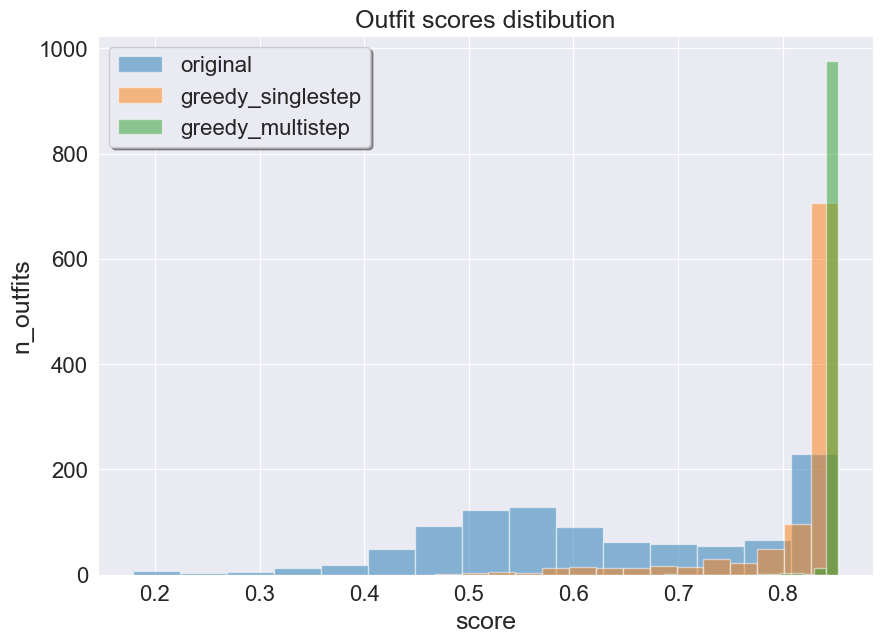

In [9]:
original_scores = []
greedy_singlestep_scores = []
greedy_multistep_scores = []

for key, res_dict in results_min5_k2_subset1000.items():
    original_scores.append(res_dict["original"])
    greedy_singlestep_scores.append(res_dict["greedy_singlestep"])
    greedy_multistep_scores.append(res_dict["greedy_multistep"])

original_scores, greedy_singlestep_scores, greedy_multistep_scores = \
    np.array(original_scores), np.array(greedy_singlestep_scores), np.array(greedy_multistep_scores)


plt.figure(figsize=(10, 7))

plt.hist(original_scores, bins=15, alpha=0.5, label="original")
plt.hist(greedy_singlestep_scores, bins=15, alpha=0.5, label="greedy_singlestep")
plt.hist(greedy_multistep_scores, bins=15, alpha=0.5, label="greedy_multistep")

plt.title("Outfit scores distibution", fontsize=18)
plt.xlabel("score", fontsize=18)
plt.ylabel("n_outfits", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, shadow=True)
plt.show()

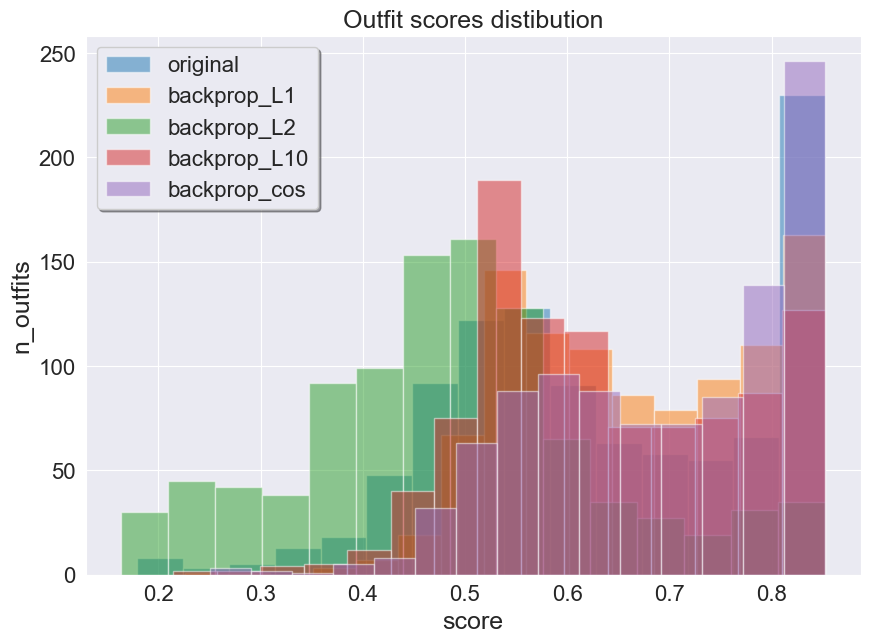

In [21]:
original_scores = []
greedy_singlestep_scores = []
greedy_multistep_scores = []
backprop_scores = []
backprop_scores_L1 = []
backprop_scores_L10 = []
backprop_scores_cos = []

for key, res_dict in results_min5_k2_subset1000.items():
    original_scores.append(res_dict["original"])
    greedy_singlestep_scores.append(res_dict["greedy_singlestep"])
    greedy_multistep_scores.append(res_dict["greedy_multistep"])
    backprop_scores.append(res_dict["backprop"])
    backprop_scores_L1.append(res_dict["backprop_L1"])
    backprop_scores_L10.append(res_dict["backprop_L10"])
    backprop_scores_cos.append(res_dict["backprop_cos"])

original_scores, greedy_singlestep_scores, greedy_multistep_scores, backprop_scores, backprop_scores_L1, backprop_scores_L10, backprop_scores_cos = \
    np.array(original_scores), np.array(greedy_singlestep_scores), \
    np.array(greedy_multistep_scores), np.array(backprop_scores), \
    np.array(backprop_scores_L1), np.array(backprop_scores_L10), np.array(backprop_scores_cos)


plt.figure(figsize=(10, 7))

plt.hist(original_scores, bins=15, alpha=0.5, label="original")
plt.hist(backprop_scores_L1, bins=15, alpha=0.5, label="backprop_L1")
plt.hist(backprop_scores, bins=15, alpha=0.5, label="backprop_L2")
plt.hist(backprop_scores_L10, bins=15, alpha=0.5, label="backprop_L10")
plt.hist(backprop_scores_cos, bins=15, alpha=0.5, label="backprop_cos")

plt.title("Outfit scores distibution", fontsize=18)
plt.xlabel("score", fontsize=18)
plt.ylabel("n_outfits", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, shadow=True,loc="upper left")

plt.show()

In [14]:
outfits_at_least_5_subset1000 = {key: value for key, value in list(outfits_at_least_5.items())[:1000]}
dataset = GraphDateset(outfits_at_least_5_subset1000, results_min5_k2_subset1000)
input_dim = len(dataset[0][1][0]["embdedding"])

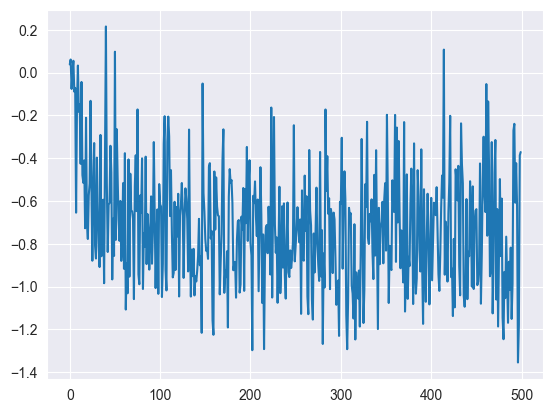

In [15]:
loss_function = lambda x, y: 1 - CosineSim(x, y)
opt_kwargs = {"lr": 1e-3, "weight_decay": 1e-6, "betas": (0.88, 0.99)}


gnn_model = GNN_model(input_dim=input_dim, hidden_dim=input_dim, n_layers=4)
optimizer = torch.optim.Adam(gnn_model.parameters(), **opt_kwargs)


grad_step = 100
n_epochs = 50

n_step = 0

loss_history = []

indices = list(range(len(dataset)))


for n_epoch in tqdm(range(n_epochs), colour="#333388"):
    random.shuffle(indices)
    optimizer.zero_grad()
    
    for i in tqdm(indices, leave=False):
        _, outfit_items, ground_truth_items, negative_items, edge_index = dataset[i]
        n_step += 1
        loss_accum = []
        outfit_items_emb = torch.tensor([elem['embdedding'] for elem in outfit_items] + np.random.randn(len(ground_truth_items), input_dim).tolist())

        embeds_pred = gnn_model(outfit_items_emb, torch.tensor(edge_index).type(torch.long).t())[-len(ground_truth_items):]
        
        negative_embeds = torch.tensor([elem['embdedding'] for elem in negative_items])
        
        ground_truth_items_emb = torch.tensor([elem["embdedding"] for elem in ground_truth_items])
        loss = (loss_function(embeds_pred, ground_truth_items_emb) - \
                loss_function(embeds_pred, negative_embeds)).mean()
        loss.backward()

        loss_accum.append(loss.detach().item())
        
        if n_step % grad_step == 0:
            optimizer.step()
            optimizer.zero_grad()
            
            loss_history.append(np.mean(loss_accum))
            loss_accum = []
            clear_output(wait=True)
            
            plt.plot(loss_history)
            plt.show()

In [16]:
similarity = CosineSim


for outfit_key, outfit_items, ground_truth_items, negative_items, edge_index in tqdm(dataset):

    if results_min5_k2_subset1000[outfit_key].get("GNN") is None:
        
        outfit_items_emb = torch.tensor([elem['embdedding'] for elem in outfit_items] + np.random.randn(len(ground_truth_items), input_dim).tolist())
    
        embeds_pred = gnn_model(outfit_items_emb, torch.tensor(edge_index).type(torch.long).t())[-len(ground_truth_items):]
        
        negative_embeds = torch.tensor([elem['embdedding'] for elem in negative_items])
        
        ground_truth_items_emb = torch.tensor([elem["embdedding"] for elem in ground_truth_items])
        
        complementary_items = []
        for emb in embeds_pred:
            complementary_items.append(get_closest_item(emb, all_items, similarity))
        
    
        final_outfit_emb = torch.tensor([elem["embdedding"] for elem in outfit_items] + \
                                        [elem["embdedding"] for elem in complementary_items]).to("cuda")
    
        set_mask = torch.zeros(len(final_outfit_emb)).to("cuda")
        
        final_score = model("cp", final_outfit_emb.unsqueeze(0), 
                            set_mask.unsqueeze(0).to("cuda")).item()
        
        results_min5_k2_subset1000[outfit_key].update({"GNN": final_score,
                                                       "GNN_complementary_items": complementary_items})

  0%|          | 0/1000 [00:00<?, ?it/s]

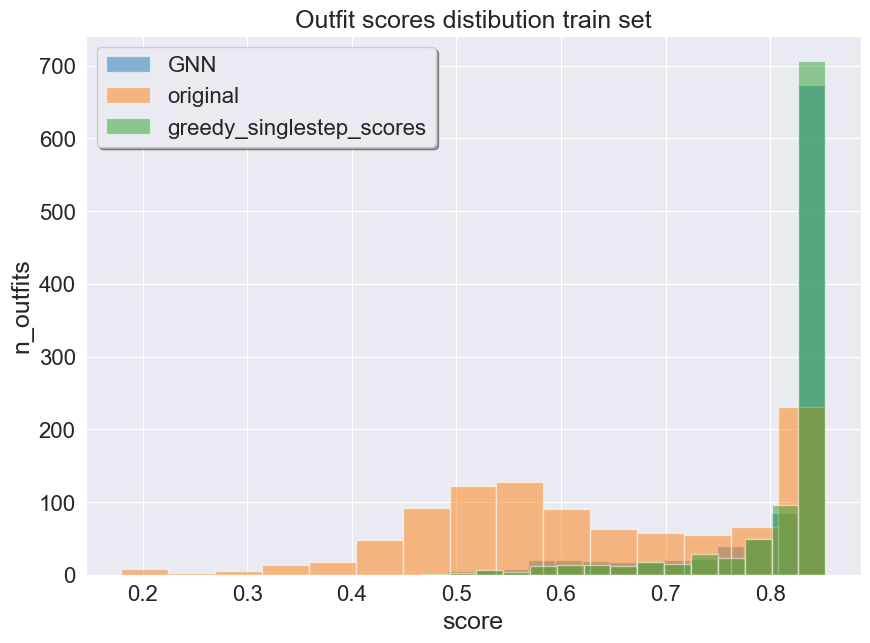

In [20]:
original_scores = []
greedy_singlestep_scores = []
greedy_multistep_scores = []
backprop_scores = []
backprop_scores_L1 = []
backprop_scores_L10 = []
backprop_scores_cos = []
GNN_scores = []

for key, res_dict in results_min5_k2_subset1000.items():
    original_scores.append(res_dict["original"])
    greedy_singlestep_scores.append(res_dict["greedy_singlestep"])
    greedy_multistep_scores.append(res_dict["greedy_multistep"])
    backprop_scores.append(res_dict["backprop"])
    backprop_scores_L1.append(res_dict["backprop_L1"])
    backprop_scores_L10.append(res_dict["backprop_L10"])
    backprop_scores_cos.append(res_dict["backprop_cos"])

    GNN_scores.append(res_dict["GNN"])

original_scores, greedy_singlestep_scores, greedy_multistep_scores, backprop_scores, backprop_scores_L1, backprop_scores_L10, backprop_scores_cos = \
    np.array(original_scores), np.array(greedy_singlestep_scores), \
    np.array(greedy_multistep_scores), np.array(backprop_scores), \
    np.array(backprop_scores_L1), np.array(backprop_scores_L10), np.array(backprop_scores_cos)


plt.figure(figsize=(10, 7))


plt.hist(GNN_scores, bins=15, alpha=0.5, label="GNN")
plt.hist(original_scores, bins=15, alpha=0.5, label="original")
# plt.hist(backprop_scores_L1, bins=15, alpha=0.5, label="backprop_scores_L1")
# plt.hist(backprop_scores, bins=15, alpha=0.5, label="backprop_scores_L2")
# plt.hist(backprop_scores_L10, bins=15, alpha=0.5, label="backprop_scores_L10")
# plt.hist(backprop_scores_cos, bins=15, alpha=0.5, label="backprop_scores_cos")
plt.hist(greedy_singlestep_scores, bins=15, alpha=0.5, label="greedy_singlestep")
# plt.hist(greedy_multistep_scores, bins=15, alpha=0.5, label="greedy_multistep_scores")

plt.title("Outfit scores distibution on train set", fontsize=18)
plt.xlabel("score", fontsize=18)
plt.ylabel("n_outfits", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, shadow=True,loc="upper left")

plt.show()

In [22]:
with open("data/Re-PolyVore_greedy_results_min5_k2_subset1000.json", "w", encoding="utf-8") as f:
    json.dump(results_min5_k2_subset1000, f, indent=4)

In [23]:
with open("data/Re-PolyVore_greedy_results_min5_k2_test_set_1000.json", "r", encoding="utf-8") as f:
    results_min5_k2_test_set_1000 = json.load(f)

In [24]:
outfits_at_least_5_test_set_1000 = {key: value for key, value in list(outfits_at_least_5.items())[1000:2000]}
test_dataset = GraphDateset(outfits_at_least_5_test_set_1000, results_min5_k2_test_set_1000)
input_dim = len(test_dataset[0][1][0]["embdedding"])

In [25]:
similarity = CosineSim


for outfit_key, outfit_items, ground_truth_items, negative_items, edge_index in tqdm(test_dataset):

    if results_min5_k2_test_set_1000[outfit_key].get("GNN") is None:
        
        outfit_items_emb = torch.tensor([elem['embdedding'] for elem in outfit_items] + np.random.randn(len(ground_truth_items), input_dim).tolist())
    
        embeds_pred = gnn_model(outfit_items_emb, torch.tensor(edge_index).type(torch.long).t())[-len(ground_truth_items):]
        
        negative_embeds = torch.tensor([elem['embdedding'] for elem in negative_items])
        
        ground_truth_items_emb = torch.tensor([elem["embdedding"] for elem in ground_truth_items])
        
        complementary_items = []
        for emb in embeds_pred:
            complementary_items.append(get_closest_item(emb, all_items, similarity))
        
    
        final_outfit_emb = torch.tensor([elem["embdedding"] for elem in outfit_items] + \
                                        [elem["embdedding"] for elem in complementary_items]).to("cuda")
    
        set_mask = torch.zeros(len(final_outfit_emb)).to("cuda")
        
        final_score = model("cp", final_outfit_emb.unsqueeze(0), 
                            set_mask.unsqueeze(0).to("cuda")).item()
        
        results_min5_k2_test_set_1000[outfit_key].update({"GNN": final_score,
                                                       "GNN_complementary_items": complementary_items})

  0%|          | 0/1000 [00:00<?, ?it/s]

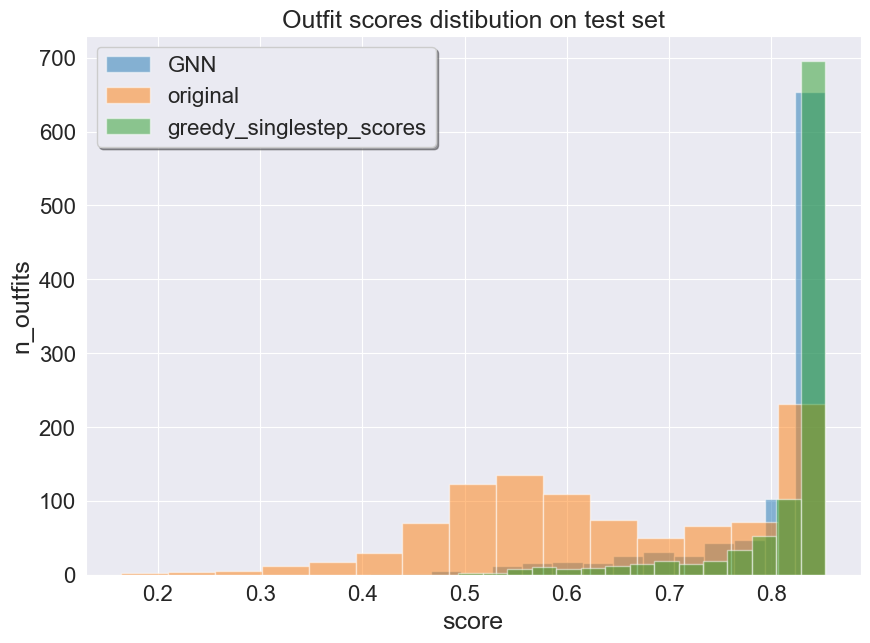

In [27]:
original_scores = []
greedy_singlestep_scores = []
greedy_multistep_scores = []
backprop_scores = []
backprop_scores_L1 = []
backprop_scores_L10 = []
backprop_scores_cos = []
GNN_scores = []

for key, res_dict in results_min5_k2_test_set_1000.items():
    original_scores.append(res_dict["original"])
    greedy_singlestep_scores.append(res_dict["greedy_singlestep"])
    greedy_multistep_scores.append(res_dict["greedy_multistep"])
    GNN_scores.append(res_dict["GNN"])

original_scores, greedy_singlestep_scores, greedy_multistep_scores = \
    np.array(original_scores), np.array(greedy_singlestep_scores), np.array(greedy_multistep_scores)


plt.figure(figsize=(10, 7))


plt.hist(GNN_scores, bins=15, alpha=0.5, label="GNN")
plt.hist(original_scores, bins=15, alpha=0.5, label="original")
plt.hist(greedy_singlestep_scores, bins=15, alpha=0.5, label="greedy_singlestep_scores")
# plt.hist(greedy_multistep_scores, bins=15, alpha=0.5, label="greedy_multistep_scores")

plt.title("Outfit scores distibution on test set", fontsize=18)
plt.xlabel("score", fontsize=18)
plt.ylabel("n_outfits", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, shadow=True,loc="upper left")

plt.show()

In [28]:
with open("data/Re-PolyVore_greedy_results_min5_k2_test_set_1000.json", "w", encoding="utf-8") as f:
    json.dump(results_min5_k2_test_set_1000, f, indent=4)